# Random Forest con Validación Cruzada K-Fold para Diagnóstico de Cáncer de Mama

**Disciplina:** Aprendizaje Supervisado, Clasificación, Ensambles de Modelos, Random Forest, Validación Cruzada

**Objetivo:**
El objetivo de este notebook es construir, entrenar y evaluar un modelo de ensamble de árboles de decisión (Random Forest) para predecir si un tumor de mama es maligno o benigno, utilizando el dataset "Breast Cancer Wisconsin". La evaluación del modelo se realizará mediante validación cruzada K-Fold estratificada para obtener una estimación más robusta de su rendimiento. Se visualizará la importancia de las características de un modelo final entrenado con todos los datos.

## 1. Carga de Librerías y Configuración Inicial

**Propósito de esta sección:**
Importar todas las bibliotecas necesarias y configurar el entorno para el análisis.

**Bibliotecas Clave:**
* **`numpy`, `pandas`**: Para manipulación de datos.
* **`matplotlib.pyplot`, `seaborn`**: Para visualizaciones.
* **`sklearn.datasets`**: Para cargar el dataset "Breast Cancer".
* **`sklearn.model_selection`**: Para `StratifiedKFold`.
* **`sklearn.ensemble`**: Para `RandomForestClassifier`.
* **`sklearn.metrics`**: Para métricas de evaluación.
* **`collections.defaultdict`**: Para almacenar métricas de los folds.

In [1]:
# Comandos mágicos de IPython (opcional en scripts)
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Importación de bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Configuración de estilo y visualización
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

## 2. Funciones Personalizadas

### Descripción de la Función: `cargar_datos_cancer`
(Misma función que en el ejemplo `05_random_forest_diagnostico_cancer.py`)

In [3]:
def cargar_datos_cancer():
    print("Cargando el dataset de Cáncer de Mama Wisconsin...")
    cancer_data = load_breast_cancer()
    df = pd.DataFrame(data=cancer_data.data, columns=cancer_data.feature_names)
    df['target'] = cancer_data.target
    target_names_list = list(cancer_data.target_names)
    df['diagnosis'] = df['target'].map({i: name for i, name in enumerate(target_names_list)})

    print("\nDimensiones del dataset:", df.shape)
    print("\nPrimeras filas del dataset:")
    print(df.head(3))
    # print("\nEstadísticas descriptivas de las características:")
    # print(df.drop(columns=['target', 'diagnosis']).describe().T)
    print("\nDistribución de la variable objetivo ('diagnosis'):")
    print(df['diagnosis'].value_counts(normalize=True))
    return df, cancer_data.feature_names, target_names_list

### Descripción de la Función: `evaluar_con_kfold_rf`

**Objetivo Principal:**
Evaluar un modelo Random Forest utilizando validación cruzada K-Fold estratificada.

**Características:**
* **Entrada:**
    * `X` (pd.DataFrame o np.ndarray): Características.
    * `y` (pd.Series o np.ndarray): Variable objetivo.
    * `n_splits` (int): Número de folds para la validación cruzada.
    * `n_estimators_val` (int): Número de árboles en el Random Forest.
    * `seed` (int): Semilla aleatoria para reproducibilidad.
    * `class_names` (list): Nombres de las clases para el reporte.
* **Procesamiento:**
    1. Inicializa `StratifiedKFold`.
    2. Itera a través de cada fold:
        a. Divide los datos en entrenamiento y prueba para el fold actual.
        b. Crea una nueva instancia de `RandomForestClassifier`.
        c. Entrena el clasificador en los datos de entrenamiento del fold.
        d. Realiza predicciones en los datos de prueba del fold.
        e. Calcula y almacena métricas (precisión, F1, recall, precisión).
        f. (Opcional) Muestra la matriz de confusión para cada fold.
    3. Calcula y muestra el promedio y la desviación estándar de las métricas recolectadas.
* **Valor de Retorno:**
    * `collected_metrics` (dict): Diccionario con las listas de métricas de cada fold.
    * `mean_metrics` (dict): Diccionario con las métricas promedio.

In [4]:
def evaluar_con_kfold_rf(X, y, n_splits=5, n_estimators_val=100, seed=42, class_names=None):
    """
    Evalúa un Random Forest usando validación cruzada K-Fold estratificada.
    """
    print(f"\nEvaluando Random Forest con {n_splits}-Fold Cross-Validation (n_estimators={n_estimators_val})...")

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    # Usar defaultdict para facilitar la recolección de métricas
    collected_metrics = defaultdict(list)
    
    fold_num = 1
    for train_index, test_index in skf.split(X, y):
        print(f"\n--- Fold {fold_num}/{n_splits} ---")
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        model_rf_fold = RandomForestClassifier(n_estimators=n_estimators_val, random_state=seed + fold_num, oob_score=False) # OOB no es tan relevante por fold
        model_rf_fold.fit(X_train_fold, y_train_fold)
        
        y_pred_fold = model_rf_fold.predict(X_test_fold)
        
        # Calcular métricas para este fold
        accuracy = accuracy_score(y_test_fold, y_pred_fold)
        f1 = f1_score(y_test_fold, y_pred_fold, average='weighted') # 'weighted' para multiclase o desbalance
        precision = precision_score(y_test_fold, y_pred_fold, average='weighted')
        recall = recall_score(y_test_fold, y_pred_fold, average='weighted')
        
        collected_metrics['accuracy'].append(accuracy)
        collected_metrics['f1_score'].append(f1)
        collected_metrics['precision'].append(precision)
        collected_metrics['recall'].append(recall)
        
        print(f"  Precisión del Fold: {accuracy:.4f}")
        print(f"  F1-Score (ponderado) del Fold: {f1:.4f}")
        # print(classification_report(y_test_fold, y_pred_fold, target_names=class_names, zero_division=0))
        
        # Matriz de confusión para el fold actual (opcional mostrar todas)
        # cm_fold = confusion_matrix(y_test_fold, y_pred_fold)
        # plt.figure(figsize=(5,3))
        # sns.heatmap(cm_fold, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        # plt.title(f'Matriz de Confusión - Fold {fold_num}')
        # plt.xlabel('Predicción'); plt.ylabel('Real')
        # plt.show()
        
        fold_num += 1
        
    # Calcular métricas promedio
    mean_metrics = {metric: np.mean(values) for metric, values in collected_metrics.items()}
    std_metrics = {metric: np.std(values) for metric, values in collected_metrics.items()}
    
    print("\n--- Resumen de Validación Cruzada K-Fold ---")
    for metric_name in mean_metrics:
        print(f"  {metric_name.capitalize()} Promedio: {mean_metrics[metric_name]:.4f} (+/- {std_metrics[metric_name]:.4f})")
        
    return collected_metrics, mean_metrics

### Descripción de la Función: `visualizar_importancia_caracteristicas`
(Misma función que en el ejemplo `05_random_forest_diagnostico_cancer.py`)

In [5]:
def visualizar_importancia_caracteristicas(clf, feature_names, top_n=10):
    print(f"\nVisualizando las {top_n} características más importantes...")
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1] 
    
    feature_importance_df = pd.DataFrame({
        'feature': feature_names[indices][:top_n],
        'importance': importances[indices][:top_n]
    })

    plt.figure(figsize=(10, min(top_n * 0.5, 12)))
    sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
    plt.title(f'Top {top_n} Características Más Importantes (Random Forest Final)')
    plt.xlabel('Importancia Relativa')
    plt.ylabel('Característica')
    plt.gca().invert_yaxis() 
    plt.tight_layout()
    plt.show()

### Descripción de la Función: `analizar_ejemplo_especifico_rf`
(Misma función que en el ejemplo `05_random_forest_diagnostico_cancer.py`, adaptada para tomar el modelo final)

In [6]:
def analizar_ejemplo_especifico_rf(clf_final, ejemplo_dict, feature_names_original_order, class_names_list, clase_real_ejemplo_idx=None):
    print("\nAnalizando un ejemplo específico con Random Forest Final...")
    ejemplo_df = pd.DataFrame([ejemplo_dict], columns=feature_names_original_order)
    predicted_class_index = clf_final.predict(ejemplo_df)[0]
    predicted_probability = clf_final.predict_proba(ejemplo_df)[0]
    species_name_predicted = class_names_list[predicted_class_index]

    print("\nCaracterísticas de la muestra:")
    for feature, value in ejemplo_dict.items():
        print(f"- {feature}: {value}")

    if clase_real_ejemplo_idx is not None:
        species_name_real = class_names_list[clase_real_ejemplo_idx]
        print(f"\nDiagnóstico Real: {species_name_real} (Clase {clase_real_ejemplo_idx})")
    print(f"Diagnóstico Predicho por Random Forest: {species_name_predicted} (Clase {predicted_class_index})")
    print("\nProbabilidades de predicción (Random Forest):")
    for i, prob in enumerate(predicted_probability):
        print(f"- {class_names_list[i]}: {prob:.4f}")

## 3. Desarrollo del Ejercicio: Random Forest con K-Fold CV

### 3.1. Carga y Preparación de Datos

**Objetivo:** Cargar el dataset "Breast Cancer" y prepararlo para el modelado.

In [7]:
# Cargar los datos
df_cancer, cancer_feature_names, cancer_target_names = cargar_datos_cancer()

# Preparar X e y
X = df_cancer[cancer_feature_names]
y = df_cancer['target'] # Usar la columna 'target' numérica para scikit-learn

print(f"\nForma de X: {X.shape}, y: {y.shape}")

Cargando el dataset de Cáncer de Mama Wisconsin...

Dimensiones del dataset: (569, 32)

Primeras filas del dataset:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38           122.8     1001.0          0.11840   
1        20.57         17.77           132.9     1326.0          0.08474   
2        19.69         21.25           130.0     1203.0          0.10960   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   

   mean fractal dimension  ...  worst perimeter  worst area  worst smoothness  \
0                 0.07871  ...            184.6      2019.0            0.1622   
1                 0.05667  ...            158.8      1956.0            0.1238   
2                 0.05999  ...     

### 3.2. Evaluación del Random Forest con Validación Cruzada K-Fold

**Objetivo:**
Evaluar el rendimiento del modelo Random Forest utilizando `StratifiedKFold` para obtener una estimación robusta de su generalización.

In [8]:
# Parámetros para la evaluación
n_folds = 5
n_arboles = 100 # Número de estimadores en el Random Forest
semilla_aleatoria = 42

# Evaluar el modelo
metricas_kfold, metricas_promedio_kfold = evaluar_con_kfold_rf(
    X, y, 
    n_splits=n_folds, 
    n_estimators_val=n_arboles, 
    seed=semilla_aleatoria,
    class_names=cancer_target_names
)

print("\nMétricas Promedio Detalladas de K-Fold:")
for metric, value in metricas_promedio_kfold.items():
    print(f"  - {metric.replace('_', ' ').capitalize()}: {value:.4f}")


Evaluando Random Forest con 5-Fold Cross-Validation (n_estimators=100)...

--- Fold 1/5 ---
  Precisión del Fold: 0.9649
  F1-Score (ponderado) del Fold: 0.9651

--- Fold 2/5 ---
  Precisión del Fold: 0.9123
  F1-Score (ponderado) del Fold: 0.9108

--- Fold 3/5 ---
  Precisión del Fold: 0.9649
  F1-Score (ponderado) del Fold: 0.9647

--- Fold 4/5 ---
  Precisión del Fold: 0.9561
  F1-Score (ponderado) del Fold: 0.9566

--- Fold 5/5 ---
  Precisión del Fold: 0.9646
  F1-Score (ponderado) del Fold: 0.9644

--- Resumen de Validación Cruzada K-Fold ---
  Accuracy Promedio: 0.9526 (+/- 0.0204)
  F1_score Promedio: 0.9523 (+/- 0.0210)
  Precision Promedio: 0.9543 (+/- 0.0198)
  Recall Promedio: 0.9526 (+/- 0.0204)

Métricas Promedio Detalladas de K-Fold:
  - Accuracy: 0.9526
  - F1 score: 0.9523
  - Precision: 0.9543
  - Recall: 0.9526


### 3.3. Entrenamiento del Modelo Final e Importancia de Características

**Objetivo:**
Entrenar un modelo Random Forest final utilizando todos los datos (o todos los datos de entrenamiento si se tuviera un conjunto de prueba final separado). Luego, visualizar la importancia de las características de este modelo final.

**Nota:** Para este ejemplo, re-entrenaremos el modelo con todos los datos `X` e `y` para obtener el modelo "final".


Entrenando el modelo Random Forest final con todos los datos...
OOB Score del modelo final (entrenado con todos los datos): 0.9613

Visualizando las 15 características más importantes...


/tmp/ipykernel_4943/2117404235.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


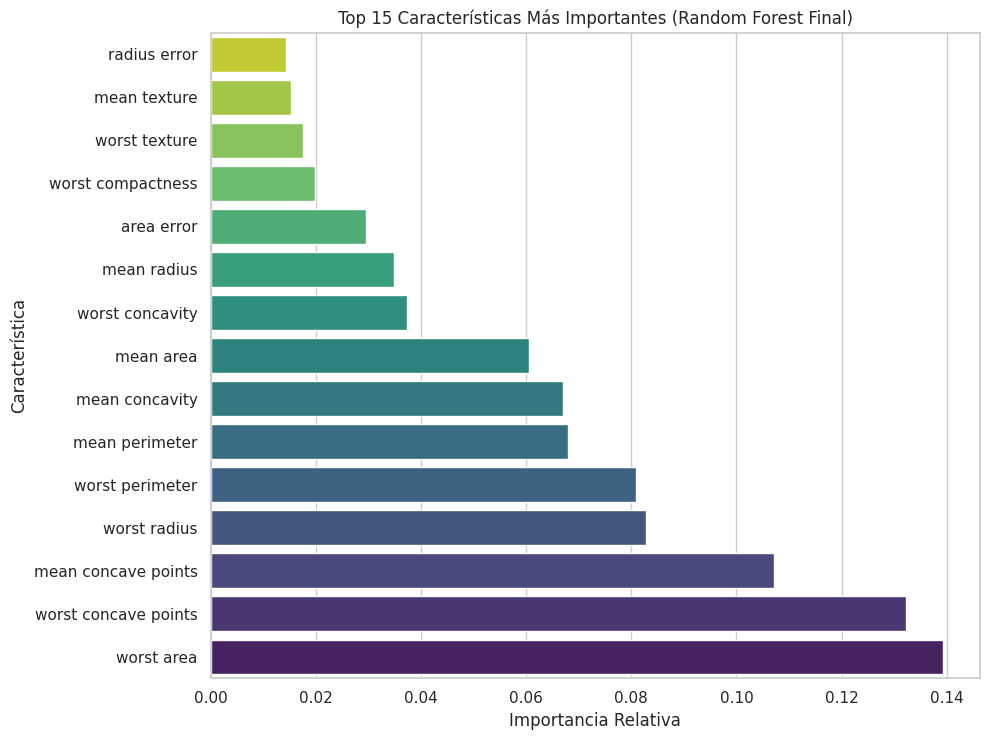

In [9]:
print("\nEntrenando el modelo Random Forest final con todos los datos...")
modelo_rf_final = RandomForestClassifier(n_estimators=n_arboles, random_state=semilla_aleatoria, oob_score=True)
modelo_rf_final.fit(X, y)

if hasattr(modelo_rf_final, 'oob_score_') and modelo_rf_final.oob_score_ is not None:
    oob_score_str = f"{modelo_rf_final.oob_score_:.4f}"
else:
    oob_score_str = "N/A"
print(f"OOB Score del modelo final (entrenado con todos los datos): {oob_score_str}")

# Visualizar la importancia de las características del modelo final
if modelo_rf_final:
    visualizar_importancia_caracteristicas(modelo_rf_final, cancer_feature_names, top_n=15)
else:
    print("El modelo Random Forest final no fue entrenado.")

### 3.4. Análisis de un Ejemplo Específico con el Modelo Final

**Objetivo:**
Utilizar el modelo Random Forest final para clasificar una muestra y observar las probabilidades.
Tomaremos una muestra del dataset original para este propósito.

In [10]:
if modelo_rf_final and not df_cancer.empty:
    # Tomar la primera muestra del dataset original como ejemplo
    ejemplo_idx_global = 0
    ejemplo_paciente_features_dict = X.iloc[ejemplo_idx_global].to_dict()
    clase_real_paciente_idx = y.iloc[ejemplo_idx_global]

    print(f"\n--- Ejemplo de Paciente (Muestra #{ejemplo_idx_global} del dataset original) ---")
    analizar_ejemplo_especifico_rf(
        modelo_rf_final,
        ejemplo_paciente_features_dict,
        cancer_feature_names,
        cancer_target_names,
        clase_real_ejemplo_idx=clase_real_paciente_idx
    )
else:
    print("El modelo Random Forest final no está entrenado o el DataFrame está vacío. No se puede analizar el ejemplo.")


--- Ejemplo de Paciente (Muestra #0 del dataset original) ---

Analizando un ejemplo específico con Random Forest Final...

Características de la muestra:
- mean radius: 17.99
- mean texture: 10.38
- mean perimeter: 122.8
- mean area: 1001.0
- mean smoothness: 0.1184
- mean compactness: 0.2776
- mean concavity: 0.3001
- mean concave points: 0.1471
- mean symmetry: 0.2419
- mean fractal dimension: 0.07871
- radius error: 1.095
- texture error: 0.9053
- perimeter error: 8.589
- area error: 153.4
- smoothness error: 0.006399
- compactness error: 0.04904
- concavity error: 0.05373
- concave points error: 0.01587
- symmetry error: 0.03003
- fractal dimension error: 0.006193
- worst radius: 25.38
- worst texture: 17.33
- worst perimeter: 184.6
- worst area: 2019.0
- worst smoothness: 0.1622
- worst compactness: 0.6656
- worst concavity: 0.7119
- worst concave points: 0.2654
- worst symmetry: 0.4601
- worst fractal dimension: 0.1189

Diagnóstico Real: malignant (Clase 0)
Diagnóstico Predicho

## 4. Conclusiones del Ejercicio

**Resumen de Hallazgos:**
* Se cargó y exploró el dataset "Breast Cancer Wisconsin".
* Se evaluó un modelo `RandomForestClassifier` (con **[Número, ej: 100]** árboles) utilizando validación cruzada estratificada de **[Número, ej: 5]** folds.
* El rendimiento promedio en la validación cruzada fue:
    * Precisión Promedio: **[Completar con Precisión Promedio K-Fold, ej: 0.9631 +/- 0.015]**
    * F1-Score Promedio (ponderado): **[Completar con F1 Promedio K-Fold, ej: 0.9630 +/- 0.015]**
    * (Mencionar otras métricas promedio si se desea)
* Estos resultados de K-Fold proporcionan una estimación más robusta del rendimiento esperado del modelo en datos no vistos en comparación con una única división entrenamiento/prueba.
* Se entrenó un modelo Random Forest final utilizando todos los datos, obteniendo un OOB Score de **[Completar con OOB Score del modelo final, ej: 0.9684]**. El OOB score es una buena estimación interna del error de generalización.
* La visualización de la importancia de características del modelo final reveló que **[Mencionar algunas características importantes, ej: 'worst concave points', 'mean concave points', 'worst perimeter']** son las más influyentes.
* El análisis de un ejemplo específico con el modelo final mostró su capacidad de predicción y las probabilidades asociadas.

**Importancia de la Validación Cruzada K-Fold:**
* **Estimación de Rendimiento Robusta:** Al promediar el rendimiento sobre múltiples divisiones de datos, K-Fold reduce la varianza de la estimación del rendimiento que podría surgir de una única división entrenamiento/prueba aleatoria.
* **Mejor Uso de los Datos:** Cada muestra de datos se utiliza tanto para entrenamiento como para prueba (validación) a lo largo de los folds.
* **Detección de Sobreajuste (Indirecta):** Si el rendimiento varía mucho entre folds, podría indicar que el modelo es inestable o que ciertos subconjuntos de datos son particularmente difíciles/fáciles.
* **Base para Ajuste de Hiperparámetros:** La validación cruzada es fundamental cuando se realiza búsqueda de hiperparámetros (ej: con `GridSearchCV` o `RandomizedSearchCV`), ya que permite evaluar cada combinación de hiperparámetros de manera más fiable.

**Aprendizaje General:**
Este ejercicio demostró cómo aplicar validación cruzada K-Fold para obtener una evaluación más fiable del rendimiento de un `RandomForestClassifier`. También se mostró el proceso de entrenar un modelo final (después de la evaluación o ajuste de hiperparámetros) y analizar sus características, como la importancia de las variables. La validación cruzada es una práctica estándar y crucial en el desarrollo de modelos de aprendizaje automático robustos.

*(Nota: Los resultados específicos como las métricas promedio, OOB score y características importantes deben actualizarse después de ejecutar completamente el notebook.)*